In [1]:
#@title import packages
import keras
import numpy as np
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import sys

!pip install rarfile segmentation-models git+https://github.com/davej23/image-segmentation-keras.git rioxarray
from rarfile import RarFile
from sklearn.metrics import *
import rioxarray as rxr

  Cloning https://github.com/davej23/image-segmentation-keras.git to /tmp/pip-req-build-s9h1a0s0
  Running command git clone --filter=blob:none --quiet https://github.com/davej23/image-segmentation-keras.git /tmp/pip-req-build-s9h1a0s0
  Resolved https://github.com/davej23/image-segmentation-keras.git to commit e01b0a8d5859854cd9d259a618829889166439f5
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 57.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.4 MB/s eta 0:00:00:00:01
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-py3-none-any.whl size=34377 sha256=0c71edab1e9a5a755cc682590efac10

In [2]:
base_dir = r"/content/gdrive/MyDrive/mudtrain/"
#@title Read training images and normalise
training_images_list = os.listdir(r"{}train/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  training_masks_list.append(n)
  a = (np.array(rxr.open_rasterio(r"{}train/images/{}".format(base_dir,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images.append(a)

## Training masks
training_masks = []
for n in training_masks_list:
  a = (np.array(rxr.open_rasterio(r"{}train/labels/{}".format(base_dir,n))))
  training_masks.append(a)


## Validation images
validation_images_list = os.listdir(r"{}val/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  validation_masks_list.append(n)
  a = (np.array(rxr.open_rasterio(r"{}val/images/{}".format(base_dir,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images.append(a)

## Validation masks
validation_masks = []
for n in validation_masks_list:
  a = (np.array(rxr.open_rasterio(r"{}val/labels/{}".format(base_dir,n))))
  validation_masks.append(a)

In [3]:
#@title Pre-process data, reshaping and transposing
for i in range(len(training_images)):
  training_images[i] = training_images[i].astype('float32')
  training_images[i] = training_images[i].T

for i in range(len(training_masks)):
  training_masks[i] = training_masks[i].reshape(1,256,256)
  training_masks[i] = training_masks[i].T

for i in range(len(validation_images)):
  validation_images[i] = validation_images[i].astype('float32')
  validation_images[i] = validation_images[i].T

for i in range(len(validation_masks)):
  validation_masks[i] = validation_masks[i].reshape(1,256,256)
  validation_masks[i] = validation_masks[i].T


for i in range(len(training_images)):
  training_images[i] = training_images[i].reshape(256,256,10)

for i in range(len(validation_images)):
  validation_images[i] = validation_images[i].reshape(256,256,10)


In [4]:
images=np.vstack([training_images])
val_images=np.vstack([validation_images])
images.shape

(889, 256, 256, 10)

In [5]:
masks=np.vstack([training_masks])
val_masks=np.vstack([validation_masks])
val_masks.shape

(223, 256, 256, 1)

In [6]:
import gc
del training_images,validation_images,training_masks,validation_masks,
training_images_list,validation_images_list,
training_masks_list,validation_masks_list
gc.collect()

889

In [17]:
del images,masks,val_images,val_masks

In [7]:
#@title boundary loss
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models

#Shape of semantic segmentation mask
OUTPUT_SHAPE = (256, 256, 1)
def boundary_loss(y_true, y_pred):

    """
    Paper Implemented : https://arxiv.org/abs/1905.07852
    Using Binary Segmentation mask, generates boundary mask on fly and claculates boundary loss.
    :param y_true:
    :param y_pred:
    :return:
    """
    y_true=tf.cast(y_true,tf.float32)
    y_pred=tf.cast(y_pred,tf.float32)
    
    y_pred_bd = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same', input_shape=OUTPUT_SHAPE)(1 - y_pred)
    y_true_bd = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same', input_shape=OUTPUT_SHAPE)(1 - y_true)
    y_pred_bd = y_pred_bd - (1 - y_pred)
    y_true_bd = y_true_bd - (1 - y_true)

    y_pred_bd_ext = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same', input_shape=OUTPUT_SHAPE)(1 - y_pred)
    y_true_bd_ext = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same', input_shape=OUTPUT_SHAPE)(1 - y_true)
    y_pred_bd_ext = y_pred_bd_ext - (1 - y_pred)
    y_true_bd_ext = y_true_bd_ext - (1 - y_true)

    P = K.sum(y_pred_bd * y_true_bd_ext) / K.sum(y_pred_bd) + 1e-7
    R = K.sum(y_true_bd * y_pred_bd_ext) / K.sum(y_true_bd) + 1e-7
    F1_Score = 2 * P * R / (P + R + 1e-7)
    loss = K.mean(1 - F1_Score)
    
    return loss

In [8]:
from keras.callbacks import ModelCheckpoint, Callback
class AlphaScheduler(Callback):
  def init(self, alpha, update_fn):
    self.alpha = alpha
    self.update_fn = update_fn
  def on_epoch_end(self, epoch, logs=None):
    updated_alpha = self.update_fn(K.get_value(self.alpha))

alpha = K.variable(1, dtype='float32')

def update_alpha(value):
  return np.clip(value - 0.005, 0.005, 1)

In [9]:
def gl_sl_wrapper(alpha):
    def gl_sl(y_true, y_pred):
        return alpha*keras.losses.binary_crossentropy(y_true, y_pred) +  (1-alpha)* boundary_loss(y_true, y_pred)
    return gl_sl

In [10]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

#convolutional block

def conv_block(x,filters, kernelsize=3, dropout=0, batchnorm=True): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv

def conv_block_one(x,filters, kernelsize=3, batchnorm=True): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv

def unet3plus(input_shape):

    filters = [32,64, 128, 256, 512]
    kernelsize = 3
    inputs =layers.Input(input_shape) 
    
    """ Encoder"""
    # block 1
    e1 = conv_block(inputs, filters[0])

    # block 2
    e2 = layers.MaxPool2D(pool_size=(2, 2))(e1) 
    e2 = conv_block(e2, filters[1]) 

    # block 3
    e3 = layers.MaxPool2D(pool_size=(2, 2))(e2) 
    e3 = conv_block(e3, filters[2])

    # block 4
    e4 = layers.MaxPool2D(pool_size=(2, 2))(e3) 
    e4 = conv_block(e4, filters[3]) 

    # block 5
    # bottleneck layer
    e5 = layers.MaxPool2D(pool_size=(2, 2))(e4) 
    e5 = conv_block(e5, filters[4])  

    """ Decoder """
    cat_channels = filters[0]
    cat_blocks = len(filters)
    upsample_channels = cat_blocks * cat_channels

    """ d4 """
    e1_d4 = layers.MaxPool2D(pool_size=(8, 8))(e1)  
    e1_d4 = conv_block_one(e1_d4, cat_channels) 

    e2_d4 = layers.MaxPool2D(pool_size=(4, 4))(e2)  
    e2_d4 = conv_block_one(e2_d4, cat_channels)  

    e3_d4 = layers.MaxPool2D(pool_size=(2, 2))(e3)  
    e3_d4 = conv_block_one(e3_d4, cat_channels) 

    e4_d4 = conv_block_one(e4, cat_channels) 

    e5_d4 = layers.UpSampling2D(size=(2, 2))(e5) 
    e5_d4 = conv_block_one(e5_d4, cat_channels)  

    d4 = layers.concatenate([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = conv_block_one(d4, upsample_channels) 

    """ d3 """
    e1_d3 = layers.MaxPool2D(pool_size=(4, 4))(e1) 
    e1_d3 = conv_block_one(e1_d3, cat_channels)  

    e2_d3 = layers.MaxPool2D(pool_size=(2, 2))(e2) 
    e2_d3 = conv_block_one(e2_d3, cat_channels) 

    e3_d3 = conv_block_one(e3, cat_channels) 

    e4_d3 = layers.UpSampling2D(size=(2, 2))(d4) 
    e4_d3 = conv_block_one(e4_d3, cat_channels)

    e5_d3 = layers.UpSampling2D(size=(4, 4))(e5) 
    e5_d3 = conv_block_one(e5_d3, cat_channels)

    d3 = layers.concatenate([e1_d3, e2_d3, e3_d3, e4_d3, e5_d3])
    d3 = conv_block_one(d3, upsample_channels) 

    """ d2 """
    e1_d2 = layers.MaxPool2D(pool_size=(2, 2))(e1)
    e1_d2 = conv_block_one(e1_d2, cat_channels) 

    e2_d2 = conv_block_one(e2, cat_channels) 

    d3_d2 = layers.UpSampling2D(size=(2, 2))(d3)  
    d3_d2 = conv_block_one(d3_d2, cat_channels) 

    d4_d2 = layers.UpSampling2D(size=(4, 4))(d4) 
    d4_d2 = conv_block_one(d4_d2, cat_channels) 

    e5_d2 = layers.UpSampling2D(size=(8, 8))(e5)
    e5_d2 = conv_block_one(e5_d2, cat_channels) 

    d2 = layers.concatenate([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = conv_block_one(d2, upsample_channels) 

    """ d1 """
    e1_d1 = conv_block_one(e1, cat_channels)  

    d2_d1 = layers.UpSampling2D(size=(2, 2))(d2)
    d2_d1 = conv_block_one(d2_d1, cat_channels)

    d3_d1 = layers.UpSampling2D(size=(4, 4))(d3) 
    d3_d1 = conv_block_one(d3_d1, cat_channels) 

    d4_d1 = layers.UpSampling2D(size=(8, 8))(d4) 
    d4_d1 = conv_block_one(d4_d1, cat_channels) 

    e5_d1 = layers.UpSampling2D(size=(16, 16))(e5) 
    e5_d1 = conv_block_one(e5_d1, cat_channels) 

    d1 = layers.concatenate([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1, ])
    d1 = conv_block_one(d1, upsample_channels) 

    conv_final = layers.Conv2D(1, kernel_size=(1,1))( d1)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final) 
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [11]:
unet = unet3plus(input_shape=(256,256,10))
# gl_sl_wrapper(alpha)
unet.compile(optimizer = adam_v2.Adam(learning_rate = 1e-4), loss =gl_sl_wrapper(alpha), metrics = ['accuracy'])
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                0)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  2912        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                         factor=0.1,
                         patience=10,
                         verbose=1,
                         mode='auto',
                         min_delta=0.00003,
                         cooldown=0,
                         min_lr=0)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,verbose=1,mode='min')
save_model= ModelCheckpoint('unet3_hybrid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
unet.fit(images, masks, validation_data=(val_images,val_masks), batch_size=8, epochs=1000,verbose=1,shuffle=True,callbacks=[reduce_lr,save_model,early_stop])

Epoch 1/1000
112/112 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.9063
Epoch 1: val_loss improved from inf to 0.53977, saving model to unet3_hybrid.hdf5
112/112 [==============================] - 62s 442ms/step - loss: 0.4273 - accuracy: 0.9063 - val_loss: 0.5398 - val_accuracy: 0.8054 - lr: 1.0000e-04
Epoch 2/1000
112/112 [==============================] - ETA: 0s - loss: 0.3962 - accuracy: 0.9446
Epoch 2: val_loss improved from 0.53977 to 0.44062, saving model to unet3_hybrid.hdf5
112/112 [==============================] - 46s 415ms/step - loss: 0.3962 - accuracy: 0.9446 - val_loss: 0.4406 - val_accuracy: 0.9016 - lr: 1.0000e-04
Epoch 3/1000
112/112 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.9612
Epoch 3: val_loss improved from 0.44062 to 0.38192, saving model to unet3_hybrid.hdf5
112/112 [==============================] - 46s 415ms/step - loss: 0.3793 - accuracy: 0.9612 - val_loss: 0.3819 - val_accuracy: 0.9616 - lr: 1.0000e-04

In [14]:
np.save('unet3_bybrid-history.npy',unet.history.history)

In [15]:
model_history = np.load('unet3_bybrid-history.npy', allow_pickle='TRUE').item()

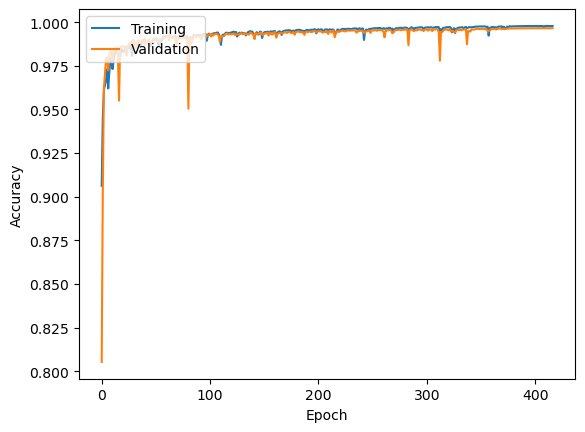

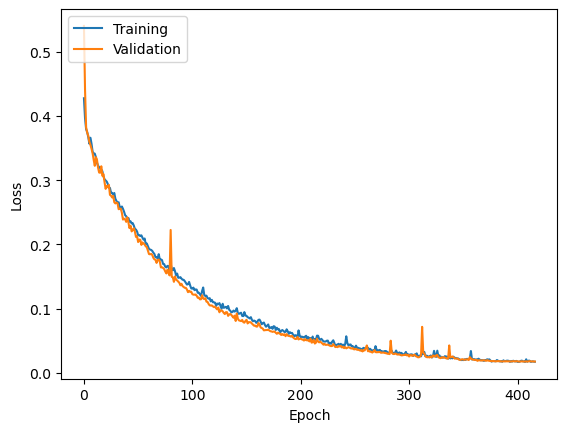

In [16]:
#@title Plot accuracy and loss 
from matplotlib import pyplot as plt
## Accuracy
plt.plot(model_history['accuracy'])
plt.plot(model_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model_history['loss'])
plt.plot(model_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [18]:
## Test images
base_dir=r'/content/gdrive/MyDrive/mudtest/'
test_images_list = os.listdir(r"{}images/".format(base_dir))
test_masks_list = []
test_images = []
for n in test_images_list:
    test_masks_list.append(n)
    a = (np.array(rxr.open_rasterio(r"{}/images/{}".format(base_dir,n))))
    a = (a-np.min(a)) / (np.max(a)-np.min(a))
    test_images.append(a)
            
## Test masks
test_masks = []
for n in test_masks_list:
    a = (np.array(rxr.open_rasterio(r"{}/labels/{}".format(base_dir,n))))
    test_masks.append(a)

In [19]:
for i in range(len(test_images)):
  test_images[i] = test_images[i].astype('float32')
  test_images[i] = test_images[i].T

for i in range(len(test_masks)):
  test_masks[i] = test_masks[i].reshape(1,256,256,1)
  test_masks[i] = test_masks[i].T

for i in range(len(test_images)):
  test_images[i] = test_images[i].reshape(-1,256,256,10)

In [20]:
#@title Returns an image or array plot of mask prediction

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [21]:
#@title Metric functions for evaluation

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()
    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 256, 256, 10))
      reconstruction = np.round(reconstruction).flatten()
      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='binary')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='binary'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='binary')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='binary'))

    return precision

def iou_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return jaccard_score(mask.flatten(), reconstruction, average='binary')

  else: # If a list of images input, find accuracy for each
    iou = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        iou.append(jaccard_score(mask[i].flatten(), reconstruction, average='binary'))

    return iou

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)
 


In [22]:

score = (score_eval(unet, test_images, test_masks))

precision = (precision_eval(unet, test_images, test_masks))

recall = (recall_eval(unet, test_images, test_masks))

iou = (iou_eval(unet, test_images, test_masks))

1/1 [==============================] - 0s 24ms/step


In [23]:
f1_score = (f1_score_eval_basic(precision, recall))

In [24]:
print('model accuracy: ', np.mean(score), np.std(score))
print('model precision: ', np.mean(precision), np.std(precision))
print('model recall: ', np.mean(recall), np.std(recall))
print('model F1-score: ', np.mean(f1_score))
print('model iou: ', np.mean(iou), np.std(iou))

model accuracy:  0.9815479938248942 0.020087597491106245
model precision:  0.9442662996113277 0.11089208343673809
model recall:  0.974992251372461 0.03653017926958792
model F1-score:  0.9593833252755611
model iou:  0.9220601264537089 0.11325616352843819
